[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/tutorials/blob/master/example_usages/COVID_19.ipynb)

This is a simple example on how to predict COVID-19 spread using well-known Gradient Boosting Decision Trees libraries (CatBoost, LightGBM and XgBoost). 

The data to train on is taken from https://www.kaggle.com/c/covid19-global-forecasting-week-1/data.
Training data contains cumulative numbers of Confirmed cases and Fatalities for the different regions for the number of consecutive dates (contained in ``Date`` field) from 2020-01-22 to 2020-03-22.
Regions are specified using two data fields: ``Province/State`` and ``Country/Region``.
Data is also enriched with region coordinates in ``Lat`` and ``Long`` fields.

The goal is to predict Confirmed cases and Fatalities for future dates based on data for previous dates. 

For the sake of simplicity no extensive preprocessing and feature engineering is performed here. If you're interested in more comprehensive analysis of this data look at the Kaggle competition notebooks: https://www.kaggle.com/c/covid19-global-forecasting-week-1/notebooks.

Install and import necessary packages

In [3]:
!pip install kaggle

# install the latest versions of all GBDT packages

!pip install catboost -U
!pip install lightgbm -U
!pip install xgboost -U

import os
import pathlib

import numpy as np
import pandas as pd
import sklearn.preprocessing

import geopy.distance

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

     |████████████████████████████████| 64.4MB 67kB/s 
     |████████████████████████████████| 1.2MB 4.5MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 109.8MB 92kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


As we download from Kaggle we need to provide Kaggle authetification cridentials. We will use the method suggested [here](https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27#gistcomment-2814834). Replace KAGGLE_USERNAME and KAGGLE_KEY with your own.

In [0]:
os.environ['KAGGLE_USERNAME'] = "XXX"
os.environ['KAGGLE_KEY'] = "YYY"

Let's download the data now.

In [5]:
kaggle_data_name = 'covid19-global-forecasting-week-1'
data_folder = os.path.join(pathlib.Path.home(), 'datasets', kaggle_data_name)

!mkdir -p ${data_folder}
!kaggle competitions download -c {kaggle_data_name} --path {data_folder}

  0% 0.00/108k [00:00<?, ?B/s]
100% 108k/108k [00:00<00:00, 43.5MB/s]
  0% 0.00/540k [00:00<?, ?B/s]
100% 540k/540k [00:00<00:00, 35.9MB/s]
  0% 0.00/947k [00:00<?, ?B/s]
100% 947k/947k [00:00<00:00, 61.7MB/s]


Let's check that data is ok.

In [6]:
!ls -l {data_folder}

total 1600
-rw-r--r-- 1 root root 111051 Apr  8 17:32 submission.csv
-rw-r--r-- 1 root root 552851 Apr  8 17:32 test.csv
-rw-r--r-- 1 root root 969831 Apr  8 17:32 train.csv


Let's load data to pandas.DataFrame.

In [7]:
df = pd.read_csv(os.path.join(data_folder,'train.csv'), parse_dates=['Date'])
df.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


Let's preprocess input data and add some simple features:

1.   Add 'Day' feature that counts days from the start of the epidemic
2.   Add 'WeekDay' feature
3.   Add 'Distance_to_Hubei' feature. Hubei province of China is the original epicentre of the epidemic.


    
    


In [8]:
def get_hubei_coords(df):
    for index, row in df.iterrows():
        if row['Province/State'] == 'Hubei':
            return (row['Lat'], row['Long'])

    raise Exception('Hubei not found in data')

def preprocess(df):
    df = df.copy()
    df.drop(columns=['Id'], inplace=True)
    
    hubei_coords = get_hubei_coords(df)
    first_date = min(df['Date'])
    
    df.fillna({'Province/State': ''}, inplace=True)
    
    df['Day'] = (df['Date'] - first_date).dt.days.astype('int32')

    hubei_coords = get_hubei_coords(df)
    
    distance_to_hubei = []
    week_day = []
        
    for index, row in df.iterrows():
        distance_to_hubei.append(geopy.distance.distance((row['Lat'], row['Long']), hubei_coords).km)
        week_day.append(row['Date'].weekday())

    df['Distance_to_Hubei'] = distance_to_hubei
    df['WeekDay'] = week_day
    
    return df

preprocessed_df = preprocess(df)
preprocessed_df.head()

,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,Day,Distance_to_Hubei,WeekDay
0,,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,0,4435.232618,2
1,,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,1,4435.232618,3
2,,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,2,4435.232618,4
3,,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,3,4435.232618,5
4,,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,4,4435.232618,6


We will split data to train and test by date.

Labels are transformed to the logarithmic scale. Logarithmic scale is natural for this task (model should weight errors between 1000 and 1100 and 100000 and 110000 approximately the same).

We will use RMSE as an objective and evaluation metric for training, that will correspond to RMSLE (Root Mean Square Logarithmic Error) metric.

$$RMSLE(labels, predictions) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}{\Big(log(labels_i + 1) - log(predictions_i + 1)\Big)^2}}$$

For prediction values in the original scale model prediction output should be transformed back to the original scale with the reverse transformation (can be preformed using numpy.expm1 function).

In [0]:
last_train_date = pd.Timestamp(2020, 3, 11)

# returns train_features_df, train_labels, test_features_df, test_labels
def get_train_and_test_data(df):
    train_df = df[df['Date'] <= last_train_date].copy()
    test_df = df[df['Date'] > last_train_date].copy()
    
    train_df.sort_values(by=['Date'])
    train_labels = {
        'ConfirmedCases': np.log1p(train_df['ConfirmedCases']),
        'Fatalities': np.log1p(train_df['Fatalities'])
    }
    train_df.drop(columns=['ConfirmedCases', 'Fatalities', 'Date'], inplace=True)
    
    test_labels = {
        'ConfirmedCases': np.log1p(test_df['ConfirmedCases']),
        'Fatalities': np.log1p(test_df['Fatalities'])
    }
    test_df.drop(columns=['ConfirmedCases', 'Fatalities', 'Date'], inplace=True)
    
    return train_df, train_labels, test_df, test_labels



Categorical features

In [0]:
cat_features = ['Province/State', 'Country/Region', 'WeekDay']

We'll train models for 1000 iterations.


In [0]:
iterations = 1000

Let's train CatBoost first. Categorical features values can be used as is in DataFrame.


In [12]:
print ('catboost version', cb.__version__)

train_df, train_labels, test_df, test_labels = get_train_and_test_data(preprocessed_df)

catboost_models = {}

for prediction_name in ['ConfirmedCases', 'Fatalities']:
    model = cb.CatBoostRegressor(
        has_time=True,
        iterations=iterations
    )

    model.fit(
        train_df,
        train_labels[prediction_name],
        eval_set=(test_df, test_labels[prediction_name]),
        cat_features=cat_features,
        verbose=100  # print metrics each 100 iterations
    )
    
    catboost_models[prediction_name] = model
    print ('CatBoost: prediction of %s: RMSLE on test = %s' % (prediction_name, model.evals_result_['validation']['RMSE'][-1]))

catboost version 0.22
Learning rate set to 0.07608
0:	learn: 1.7234085	test: 3.5386691	best: 3.5386691 (0)	total: 64.3ms	remaining: 1m 4s
100:	learn: 0.3685676	test: 2.0804581	best: 2.0804581 (100)	total: 1.36s	remaining: 12.1s
200:	learn: 0.2733765	test: 1.9753332	best: 1.9753332 (200)	total: 2.7s	remaining: 10.7s
300:	learn: 0.2262019	test: 1.9121371	best: 1.9120677 (298)	total: 4.04s	remaining: 9.38s
400:	learn: 0.1976705	test: 1.8692683	best: 1.8692537 (399)	total: 5.35s	remaining: 8s
500:	learn: 0.1781107	test: 1.8042560	best: 1.8042560 (500)	total: 6.66s	remaining: 6.63s
600:	learn: 0.1632501	test: 1.7695398	best: 1.7695398 (600)	total: 7.97s	remaining: 5.29s
700:	learn: 0.1508874	test: 1.7541809	best: 1.7541809 (700)	total: 9.28s	remaining: 3.96s
800:	learn: 0.1416807	test: 1.7333306	best: 1.7333306 (800)	total: 10.6s	remaining: 2.63s
900:	learn: 0.1347790	test: 1.7220938	best: 1.7217529 (891)	total: 11.9s	remaining: 1.31s
999:	learn: 0.1278086	test: 1.7130733	best: 1.7130733 (9

Let's look at feature importances.
For CatBoost use [PredictionValuesChange](https://catboost.ai/docs/concepts/fstr.html#fstr__regular-feature-importance).

In [13]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    print ('\nCatBoost: prediction of %s. Feature importance. Type=PredictionValuesChange' % prediction_name)
    print (catboost_models[prediction_name].get_feature_importance(type=cb.EFstrType.PredictionValuesChange, prettified=True))


CatBoost: prediction of ConfirmedCases. Feature importance. Type=PredictionValuesChange
          Feature Id  Importances
0  Distance_to_Hubei    34.660626
1     Country/Region    17.132457
2     Province/State    16.414815
3                Day    13.621041
4                Lat     9.746912
5               Long     6.513599
6            WeekDay     1.910550

CatBoost: prediction of Fatalities. Feature importance. Type=PredictionValuesChange
          Feature Id  Importances
0     Province/State    49.637990
1  Distance_to_Hubei    14.761734
2     Country/Region    12.875072
3               Long    10.726166
4                Lat     5.548307
5                Day     4.907931
6            WeekDay     1.542799


Let's train LightGBM. Categorical features has to be transformed to integer values using enumeration.

In [17]:
# returns df, dict of cat_feature -> OrdinalEncoder
def preprocess_for_lightgbm(df, cat_features):
    df = df.copy()
    encoders = {}
    for cat_feature in cat_features:
        encoder = sklearn.preprocessing.OrdinalEncoder()
        df[cat_feature] = encoder.fit_transform([df[cat_feature]])[0]
        encoders[cat_feature] = encoder
        
    return df, encoders


print ('lightgbm version', lgb.__version__)

preprocessed_for_lighgbm_df, encoders = preprocess_for_lightgbm(preprocessed_df, cat_features)

train_df, train_labels, test_df, test_labels = get_train_and_test_data(preprocessed_for_lighgbm_df)

lightgbm_models = {}

for prediction_name in ['ConfirmedCases', 'Fatalities']:
    model = lgb.LGBMRegressor(
        objective='rmse',
        n_estimators=iterations
    )

    model = model.fit(
        X=train_df,
        y=train_labels[prediction_name],
        categorical_feature=cat_features,
        eval_set=[(test_df, test_labels[prediction_name])],
        verbose=100  # print metrics each 100 iterations
    )

    lightgbm_models[prediction_name] = model
    print ('LightGBM: prediction of %s: RMSLE on test = %s' % (prediction_name, model.best_score_['valid_0']['rmse'])) 
    


lightgbm version 2.3.1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Country/Region', 'Province/State', 'WeekDay']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	valid_0's rmse: 1.96629
[200]	valid_0's rmse: 1.87323
[300]	valid_0's rmse: 1.851
[400]	valid_0's rmse: 1.83537
[500]	valid_0's rmse: 1.82451
[600]	valid_0's rmse: 1.81892
[700]	valid_0's rmse: 1.81676
[800]	valid_0's rmse: 1.81196
[900]	valid_0's rmse: 1.81034
[1000]	valid_0's rmse: 1.80805
LightGBM: prediction of ConfirmedCases: RMSLE on test = 1.8080456616778966
[100]	valid_0's rmse: 0.90422
[200]	valid_0's rmse: 0.861511
[300]	valid_0's rmse: 0.843588
[400]	valid_0's rmse: 0.830418
[500]	valid_0's rmse: 0.824959
[600]	valid_0's rmse: 0.821098
[700]	valid_0's rmse: 0.818259
[800]	valid_0's rmse: 0.815991
[900]	valid_0's rmse: 0.813314
[1000]	valid_0's rmse: 0.811237
LightGBM: prediction of Fatalities: RMSLE on test = 0.8112365813255957


Let's look at LightGBM models' feature importances. 
1. "split” means result contains numbers of times the feature is used in a model. 
2. “gain” means result contains total gains of splits which use the feature.

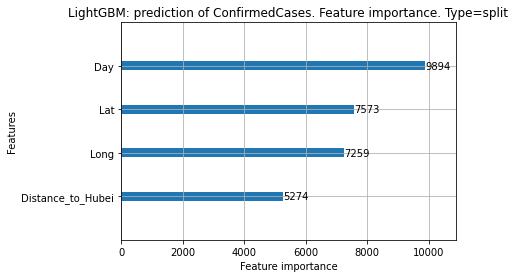

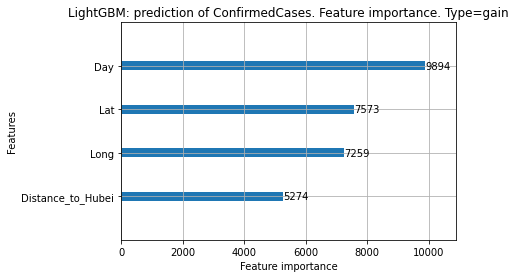

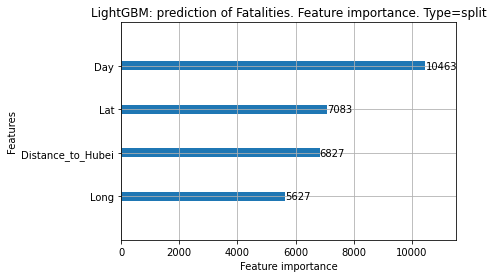

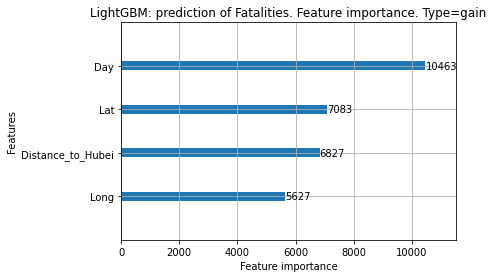

In [18]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    for importance_type in ['split', 'gain']:
        lgb.plot_importance(lightgbm_models[prediction_name], title='LightGBM: prediction of %s. Feature importance. Type=%s' % (prediction_name, importance_type))

And the third GBDT package is XgBoost. XgBoost does not support categorical features out of the box, so we will transform original categorical features to one-hot features.

In [20]:
# returns df, dict of cat_feature -> OneHotEncoder
def preprocess_for_xgboost(df, cat_features):
    df = df.copy()
    encoders = {}
    for cat_feature in cat_features:
        # xgboost doesn't support sparse columns in pandas.DataFrame input
        encoder = sklearn.preprocessing.OneHotEncoder(dtype=np.bool, sparse=False)

        ohe_matrix = encoder.fit_transform(df[cat_feature].to_numpy().reshape(-1, 1))
        ohe_df = pd.DataFrame(
            ohe_matrix,
            columns=encoder.get_feature_names([cat_feature])
        )
        df = pd.concat([df, ohe_df], axis=1)
        df.drop(cat_feature, axis=1, inplace=True)

        encoders[cat_feature] = encoder

    return df, encoders



print ('xgboost version', xgb.__version__)

preprocessed_for_xgboost_df, encoders = preprocess_for_xgboost(preprocessed_df, cat_features)

train_df, train_labels, test_df, test_labels = get_train_and_test_data(preprocessed_for_xgboost_df)

xgboost_models = {}

for prediction_name in ['ConfirmedCases', 'Fatalities']:
    model = xgb.XGBRegressor(n_estimators=iterations)

    model = model.fit(
        X=train_df,
        y=train_labels[prediction_name],
        eval_set=[(test_df, test_labels[prediction_name])],
        verbose=False,
        callbacks=[xgb.callback.print_evaluation(period=100)]
    )

    xgboost_models[prediction_name] = model
    print ('XgBoost: prediction of %s: RMSLE on test = %s' % (prediction_name, model.evals_result()['validation_0']['rmse'][-1])) 

xgboost version 1.0.2
[0]	validation_0-rmse:3.40985
[100]	validation_0-rmse:1.93904
[200]	validation_0-rmse:1.84852
[300]	validation_0-rmse:1.80822
[400]	validation_0-rmse:1.79581
[500]	validation_0-rmse:1.78997
[600]	validation_0-rmse:1.78779
[700]	validation_0-rmse:1.78733
[800]	validation_0-rmse:1.78607
[900]	validation_0-rmse:1.78558
[999]	validation_0-rmse:1.78517
XgBoost: prediction of ConfirmedCases: RMSLE on test = 1.785172
[0]	validation_0-rmse:1.20855
[100]	validation_0-rmse:0.82518
[200]	validation_0-rmse:0.80351
[300]	validation_0-rmse:0.80003
[400]	validation_0-rmse:0.79914
[500]	validation_0-rmse:0.79899
[600]	validation_0-rmse:0.79899
[700]	validation_0-rmse:0.79899
[800]	validation_0-rmse:0.79899
[900]	validation_0-rmse:0.79899
[999]	validation_0-rmse:0.79899
XgBoost: prediction of Fatalities: RMSLE on test = 0.798991


Let's look at XgBoost models' feature importances.

1. "split” means result contains numbers of times the feature is used in a model.
2. “gain” means result contains total gains of splits which use the feature.
3. ”cover” means result is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split



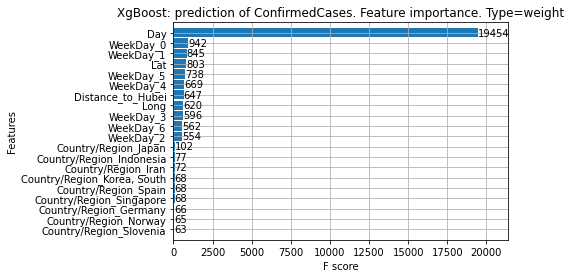

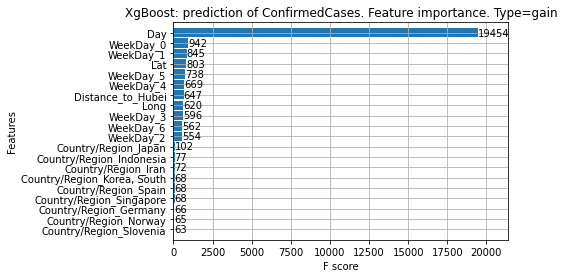

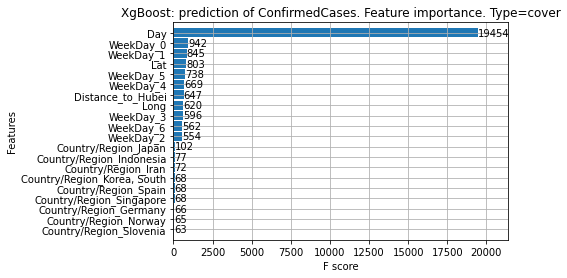

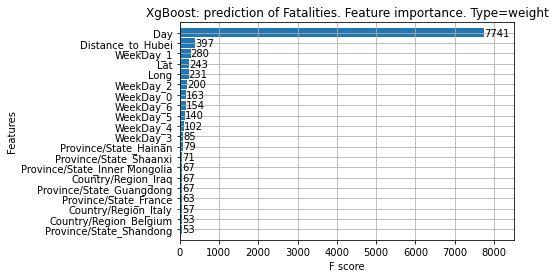

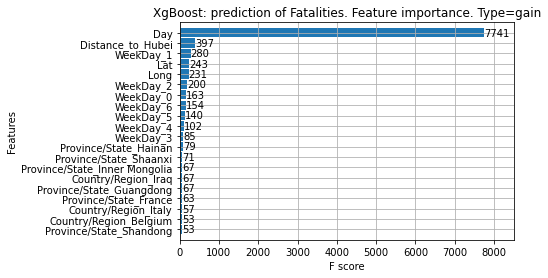

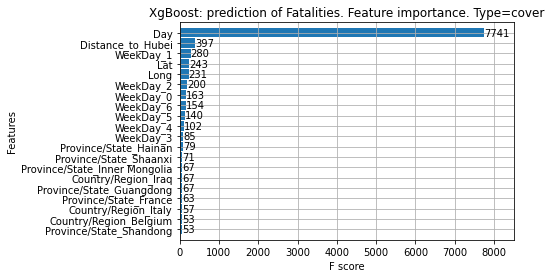

In [21]:
for prediction_name in ['ConfirmedCases', 'Fatalities']:
    for importance_type in ['weight', 'gain', 'cover']:
        xgb.plot_importance(
            xgboost_models[prediction_name],
            title='XgBoost: prediction of %s. Feature importance. Type=%s' % (prediction_name, importance_type),
            height=0.9,
            max_num_features=20
        )
